In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Load Data Pada CSV dan Proses menjadi Data Time Series

In [3]:
#Load data csv dan format data tahun bulan menjadi data frame
df = pd.read_csv('DATASET_PAJAK_HOTEL.csv')
df['tahun'] = pd.to_datetime(df['tahun_bulan'])
df.head()

,tahun_bulan,jml_setor,tahun
0,2007-1,969646,2007-01-01
1,2007-2,51237546,2007-02-01
2,2007-3,44745946,2007-03-01
3,2007-4,71632678,2007-04-01
4,2007-5,66687601,2007-05-01


In [ ]:
#Buat data tiemseries berdasar key value dari data frame
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.head()

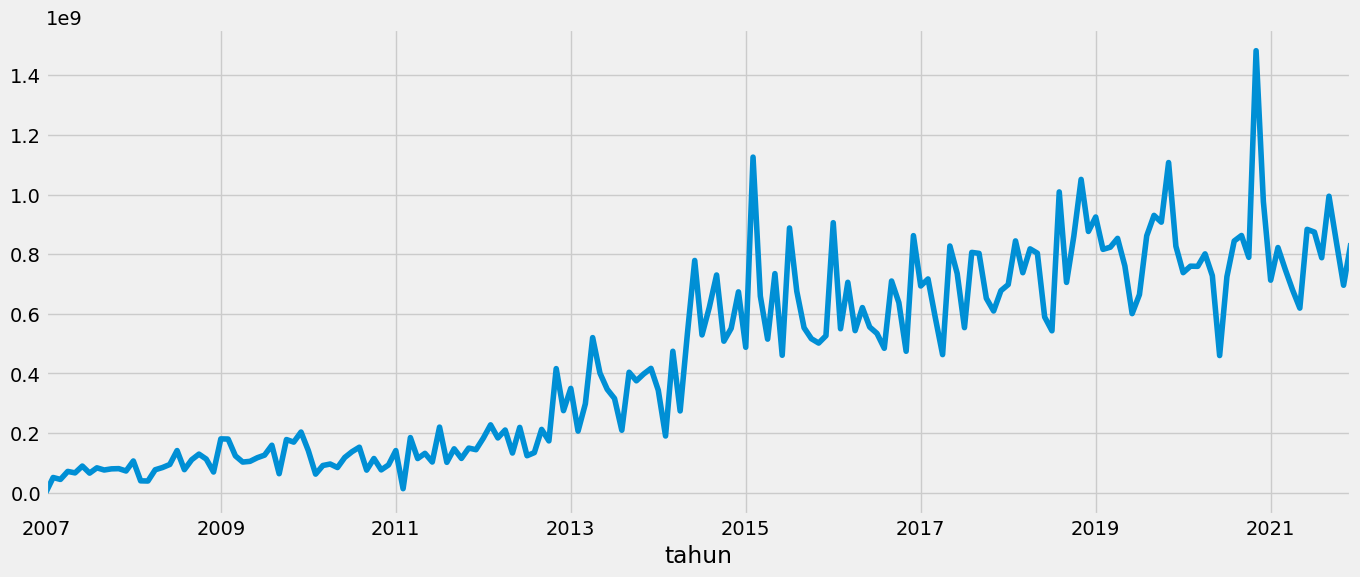

In [4]:
dts = pd.Series(data=df['jml_setor'].values, index=df['tahun'])
dts.plot(figsize=(15, 6))
plt.show()

# Mencari parameter terbaik ARIMA p, d, q

In [158]:
# Tentukan parameter p, d, dan q untuk mengambil nilai antara 0 sampai 5
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Hasilkan semua kombinasi berbeda dari triplet p, q, dan q musiman
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [159]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
best_result = [0, 0, 10000000]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(dts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{} x {} - AIC: {}'.format(param, param_seasonal, results.aic))
            if results.aic < best_result[2]:
                best_result = [param, param_seasonal, results.aic]
        except:
            continue
print('\nBest Result:', best_result)

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC: 47806.188305223965
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC: 7130.256180934119
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC: 6834.871480388493
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC: 6348.6608409449855
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC: 6876.134980581124
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC: 6821.177013715189
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC: 6386.32331125911
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC: 6348.839123758588
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC: 7569.942141614381
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC: 7041.225450078485
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC: 6793.1664915500905
ARIMA(0, 0, 1) x (0, 1, 1, 12) - AIC: 6298.967042225193
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC: 7100.224978138816
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC: 7015.349933198877
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC: 6377.272547652646
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC: 6298.38359677148
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC: 7237.731932690003
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC: 6764.3183

# Plot model diagnostics

In [176]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
mod = sm.tsa.statespace.SARIMAX(dts,
                                order=(1, 1, 1),
                                seasonal_order=(1, 2, 2, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

results = mod.fit()

print(results.summary())

 #order=(1, 0, 0),
  #                          seasonal_order=(0, 0, 0, 12),
  #                          enforce_stationarity=False,
    #                        enforce_invertibility=False)

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  180
Model:             SARIMAX(1, 1, 1)x(1, 2, [1, 2], 12)   Log Likelihood               -2660.497
Date:                                 Fri, 02 Dec 2022   AIC                           5332.995
Time:                                         09:55:02   BIC                           5350.154
Sample:                                     01-01-2007   HQIC                          5339.967
                                          - 12-01-2021                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0386      0.628      0.061      0.951      -1.193       1

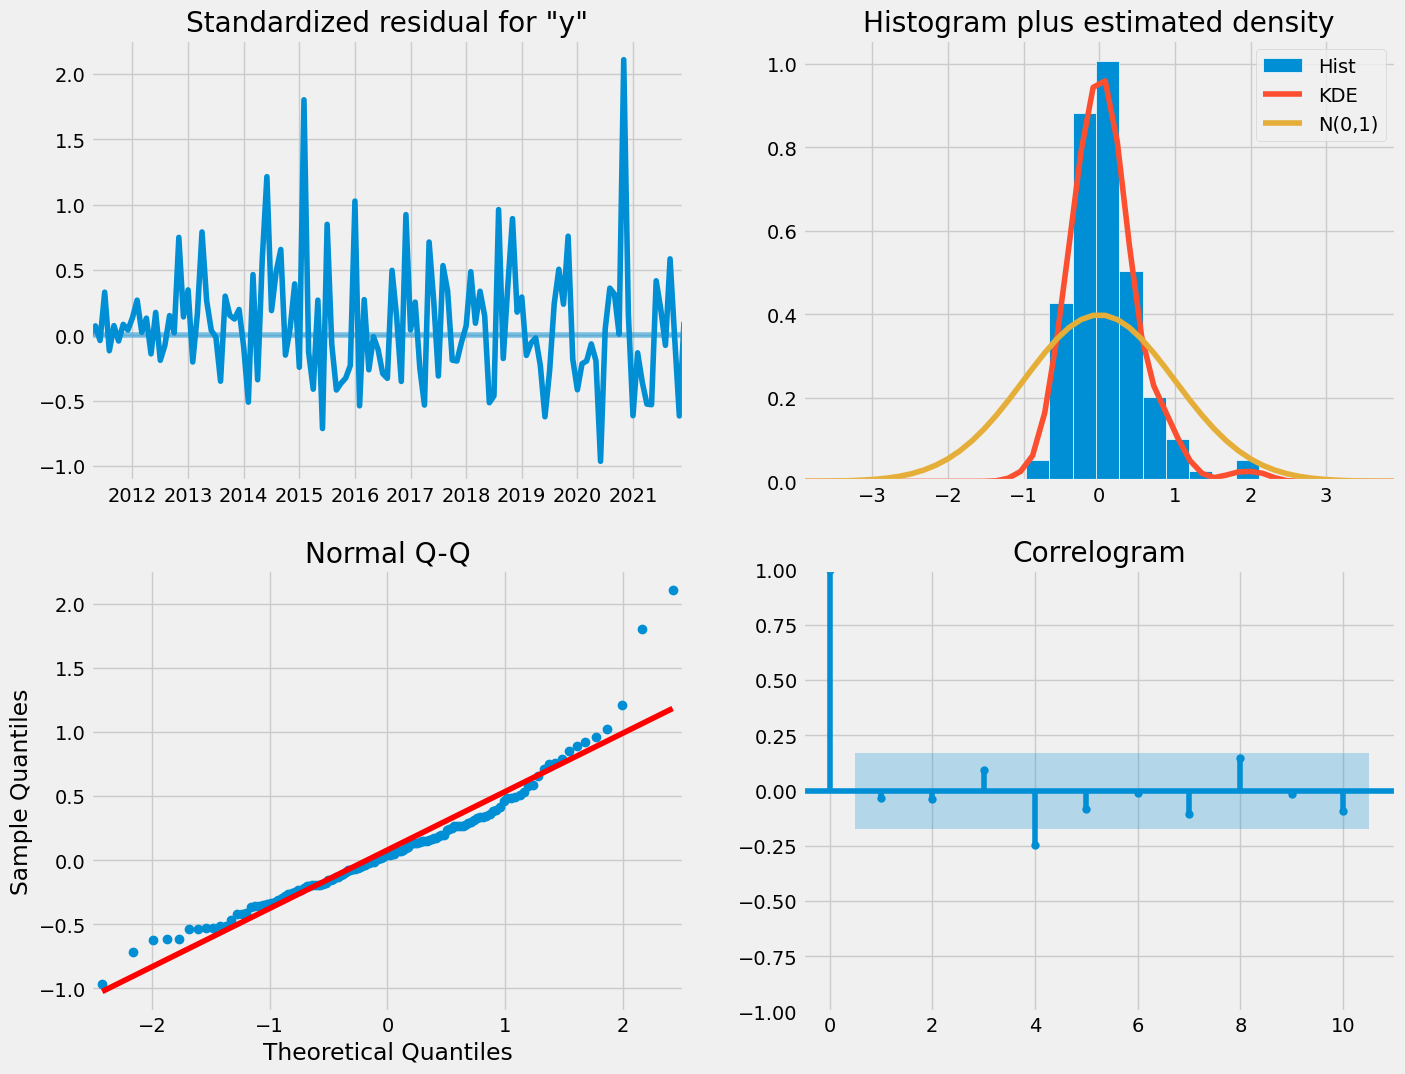

In [177]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

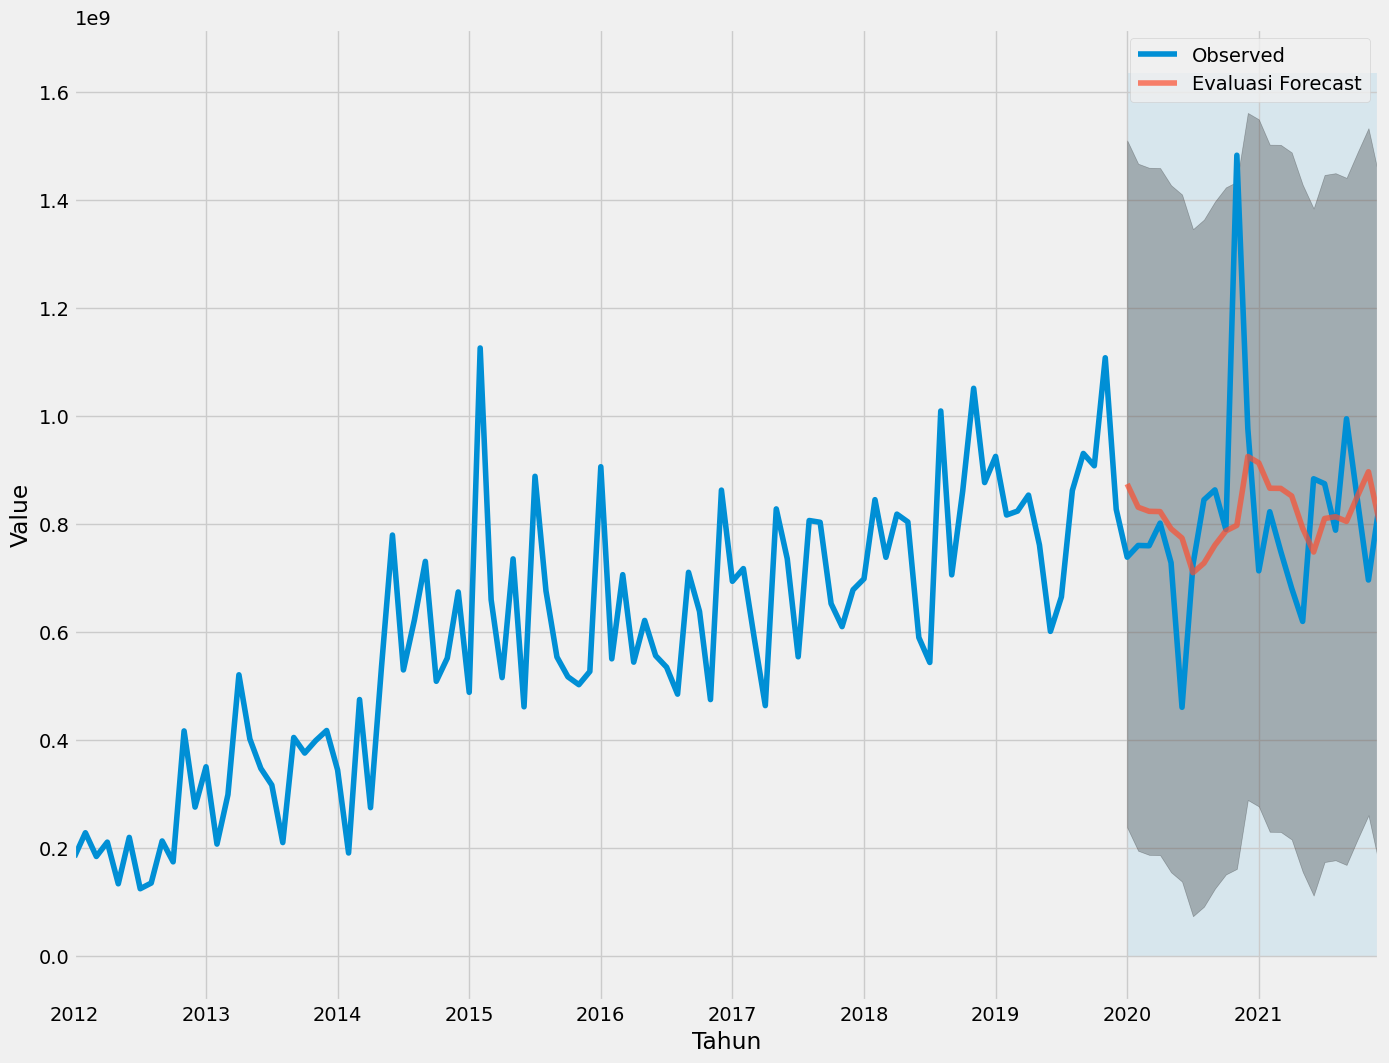

In [178]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = dts['2012':].plot(label='Observed', figsize=(15, 12))
pred.predicted_mean.plot(ax=ax, label='Evaluasi Forecast', alpha=.7)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-01-01'), dts.index[-1],alpha=.1, zorder=-1)
ax.set_xlabel('Tahun')
ax.set_ylabel('Value')
plt.legend()
plt.show()

# Prediksi data selama 2 tahun

In [179]:
# prediksi 24 langkah ke depan di masa mendatang
pred_uc = results.get_forecast(steps=24, dynamic=True)
# Dapatkan interval
pred_ci = pred_uc.conf_int()

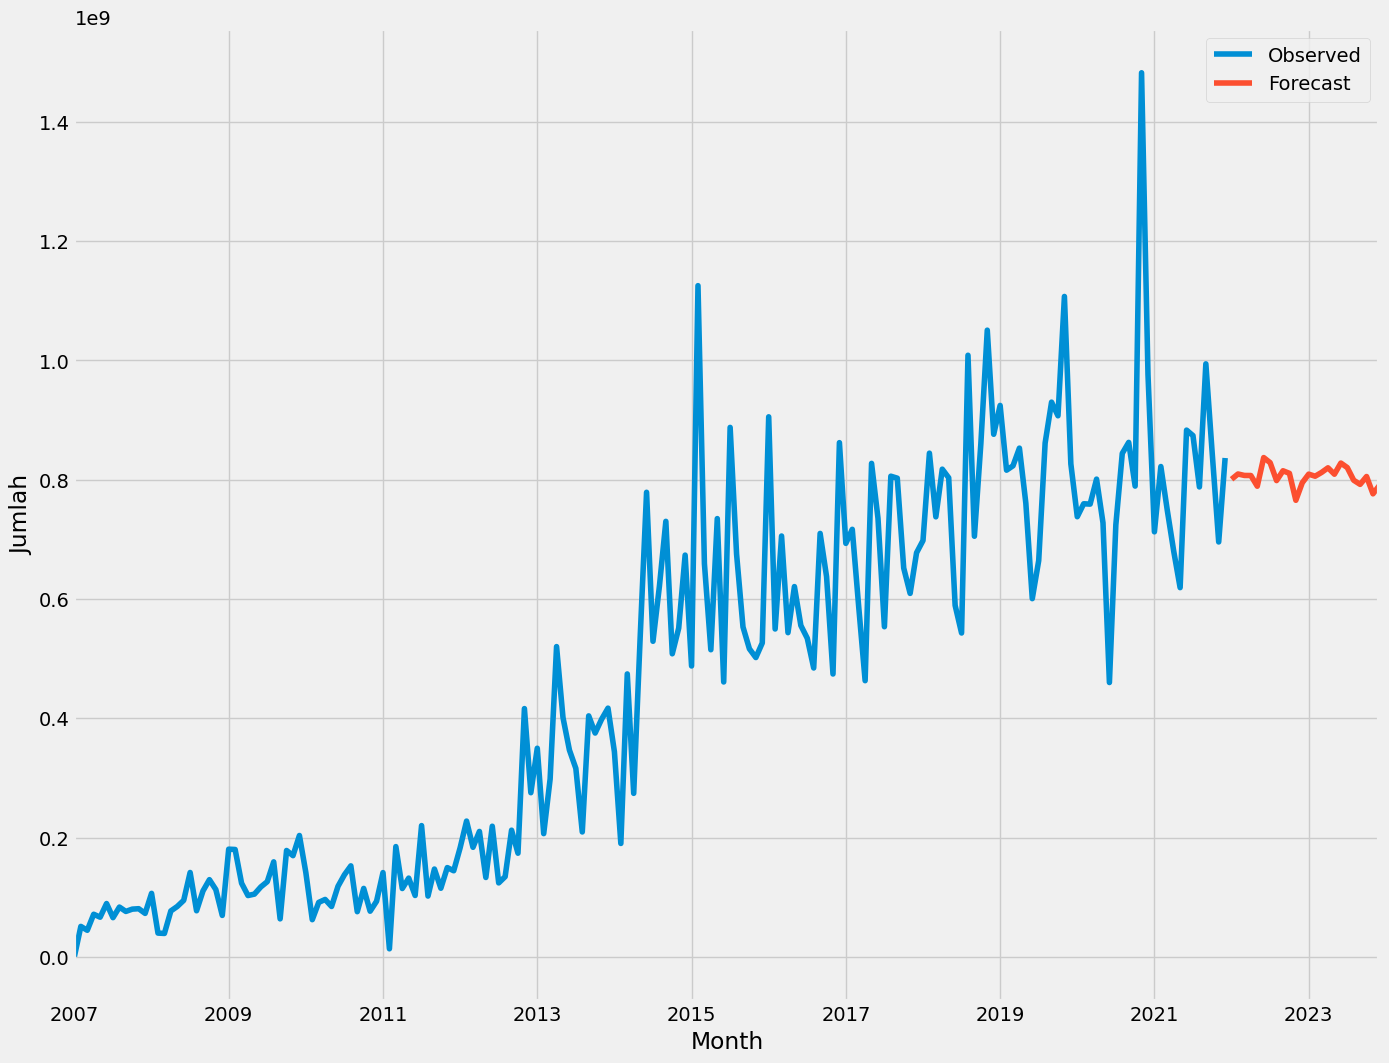

In [180]:
ax = dts.plot(label='Observed', figsize=(15, 12))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Month')
ax.set_ylabel('Jumlah')
plt.legend()
plt.show()